In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.model_selection import train_test_split
import statsmodels.api as sm

from sklearn.cluster import KMeans
!pip install kneed
from kneed import KneeLocator

import warnings
warnings.filterwarnings('ignore')

In [3]:
df_customer = pd.read_csv('Customer.csv', delimiter=';')
df_product = pd.read_csv("Product.csv", delimiter=';')
df_store = pd.read_csv('Store.csv', delimiter=';')
df_transaction = pd.read_csv('Transaction.csv', delimiter=';')

In [4]:
df_customer.shape, df_product.shape, df_store.shape, df_transaction.shape

((447, 5), (10, 3), (14, 6), (5020, 8))

In [5]:
df = pd.merge(pd.merge(pd.merge(df_customer, df_transaction, on='CustomerID'), df_product, on='ProductID'), df_store, on='StoreID')
df = df.drop(columns = 'Price_y')
df.rename(columns={'Price_x':'Price'}, inplace=True)
df

,CustomerID,Age,Gender,Marital Status,Income,TransactionID,Date,ProductID,Price,Qty,TotalAmount,StoreID,Product Name,StoreName,GroupStore,Type,Latitude,Longitude
0,1,55,1,Married,"5,12",TR54475,23/02/2022,P8,16000,1,16000,9,Oat,Lingga,Lingga,Modern Trade,"-3,654703","128,190643"
1,5,58,1,Married,"3,57",TR53643,22/05/2022,P8,16000,3,48000,9,Oat,Lingga,Lingga,Modern Trade,"-3,654703","128,190643"
2,7,31,0,Married,"4,57",TR5151,10/03/2022,P8,16000,2,32000,9,Oat,Lingga,Lingga,Modern Trade,"-3,654703","128,190643"
3,19,24,1,Single,"4,14",TR98635,18/06/2022,P8,16000,1,16000,9,Oat,Lingga,Lingga,Modern Trade,"-3,654703","128,190643"
4,28,55,0,Married,"6,08",TR9420,12/01/2022,P8,16000,3,48000,9,Oat,Lingga,Lingga,Modern Trade,"-3,654703","128,190643"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5015,403,30,0,Married,"4,06",TR21751,07/10/2022,P9,10000,5,50000,7,Yoghurt,Buana Indah,Buana,General Trade,"3,316694","114,590111"
5016,410,55,1,Married,"8,68",TR86692,05/04/2022,P9,10000,2,20000,7,Yoghurt,Buana Indah,Buana,General Trade,"3,316694","114,590111"
5017,411,19,1,Single,0,TR67993,23/10/2022,P9,10000,2,20000,7,Yoghurt,Buana Indah,Buana,General Trade,"3,316694","114,590111"
5018,427,54,0,Married,"16,88",TR28578,30/10/2022,P9,10000,3,30000,7,Yoghurt,Buana Indah,Buana,General Trade,"3,316694","114,590111"


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5020 entries, 0 to 5019
Data columns (total 18 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   CustomerID      5020 non-null   int64 
 1   Age             5020 non-null   int64 
 2   Gender          5020 non-null   int64 
 3   Marital Status  4976 non-null   object
 4   Income          5020 non-null   object
 5   TransactionID   5020 non-null   object
 6   Date            5020 non-null   object
 7   ProductID       5020 non-null   object
 8   Price           5020 non-null   int64 
 9   Qty             5020 non-null   int64 
 10  TotalAmount     5020 non-null   int64 
 11  StoreID         5020 non-null   int64 
 12  Product Name    5020 non-null   object
 13  StoreName       5020 non-null   object
 14  GroupStore      5020 non-null   object
 15  Type            5020 non-null   object
 16  Latitude        5020 non-null   object
 17  Longitude       5020 non-null   object
dtypes: int64

In [7]:
df['Income']

0        5,12
1        3,57
2        4,57
3        4,14
4        6,08
        ...  
5015     4,06
5016     8,68
5017        0
5018    16,88
5019    14,88
Name: Income, Length: 5020, dtype: object

In [8]:
df['Latitude'].head()

0    -3,654703
1    -3,654703
2    -3,654703
3    -3,654703
4    -3,654703
Name: Latitude, dtype: object

In [9]:
df['Income'] = df['Income'].replace('[,]','.', regex=True).astype('float')
df['Latitude'] = df['Latitude'].replace('[,]','.', regex=True).astype('float')
df['Longitude'] = df['Longitude'].replace('[,]','.', regex=True).astype('float')
df['Date'] = pd.to_datetime(df['Date'], format='%d/%m/%Y', dayfirst=True)

In [10]:
df['Income'].head()

0    5.12
1    3.57
2    4.57
3    4.14
4    6.08
Name: Income, dtype: float64

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5020 entries, 0 to 5019
Data columns (total 18 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   CustomerID      5020 non-null   int64         
 1   Age             5020 non-null   int64         
 2   Gender          5020 non-null   int64         
 3   Marital Status  4976 non-null   object        
 4   Income          5020 non-null   float64       
 5   TransactionID   5020 non-null   object        
 6   Date            5020 non-null   datetime64[ns]
 7   ProductID       5020 non-null   object        
 8   Price           5020 non-null   int64         
 9   Qty             5020 non-null   int64         
 10  TotalAmount     5020 non-null   int64         
 11  StoreID         5020 non-null   int64         
 12  Product Name    5020 non-null   object        
 13  StoreName       5020 non-null   object        
 14  GroupStore      5020 non-null   object        
 15  Type

###Mengecek dan Mengatasi Missing Value

In [12]:
df.isnull().sum()

CustomerID         0
Age                0
Gender             0
Marital Status    44
Income             0
TransactionID      0
Date               0
ProductID          0
Price              0
Qty                0
TotalAmount        0
StoreID            0
Product Name       0
StoreName          0
GroupStore         0
Type               0
Latitude           0
Longitude          0
dtype: int64

In [13]:
# Membuat array nilai yang tersedia di kolom 'Marital Status'
available_values = df['Marital Status'].dropna().unique()

# Mengganti setiap nilai yang hilang dengan nilai acak dari array nilai yang tersedia
for index, row in df.iterrows():
  if pd.isnull(row['Marital Status']):
    df.at[index, 'Marital Status'] = np.random.choice(available_values)

In [14]:
# Mengecek missing value setelah dilakukan pembersihan
df.isnull().sum()

CustomerID        0
Age               0
Gender            0
Marital Status    0
Income            0
TransactionID     0
Date              0
ProductID         0
Price             0
Qty               0
TotalAmount       0
StoreID           0
Product Name      0
StoreName         0
GroupStore        0
Type              0
Latitude          0
Longitude         0
dtype: int64

### Mengecek dan Mengatasi Data Duplicate

In [15]:
# Mengecek nilai dari unik dari setiap kolom
df.nunique()

CustomerID         447
Age                 54
Gender               2
Marital Status       2
Income             369
TransactionID     4908
Date               365
ProductID           10
Price               10
Qty                 10
TotalAmount         44
StoreID             14
Product Name        10
StoreName           12
GroupStore           7
Type                 2
Latitude            14
Longitude           14
dtype: int64

In [16]:
df['TransactionID'].value_counts()

TR71313    3
TR74019    2
TR38919    2
TR87715    2
TR54287    2
          ..
TR63136    1
TR11280    1
TR7587     1
TR5274     1
TR28578    1
Name: TransactionID, Length: 4908, dtype: int64

In [17]:
# Menghapus data duplikat berdasarkan kolom 'TransactionID', dengan mempertahankan baris terakhir
df.drop_duplicates(subset=['TransactionID'], keep='last', inplace=True)

In [18]:
df['TransactionID'].value_counts()

TR54475    1
TR74254    1
TR95040    1
TR8182     1
TR47837    1
          ..
TR15464    1
TR25829    1
TR29269    1
TR26836    1
TR88485    1
Name: TransactionID, Length: 4908, dtype: int64

## Forecasting

In [20]:
df_forecast = df.groupby('Date')['Qty'].sum().reset_index()
df_forecast.set_index('Date', inplace=True)
df_forecast

,Qty
Date,
2022-01-01,49
2022-01-02,59
2022-01-03,63
2022-01-04,43
2022-01-05,30
...,...
2022-12-27,70
2022-12-28,68
2022-12-29,42


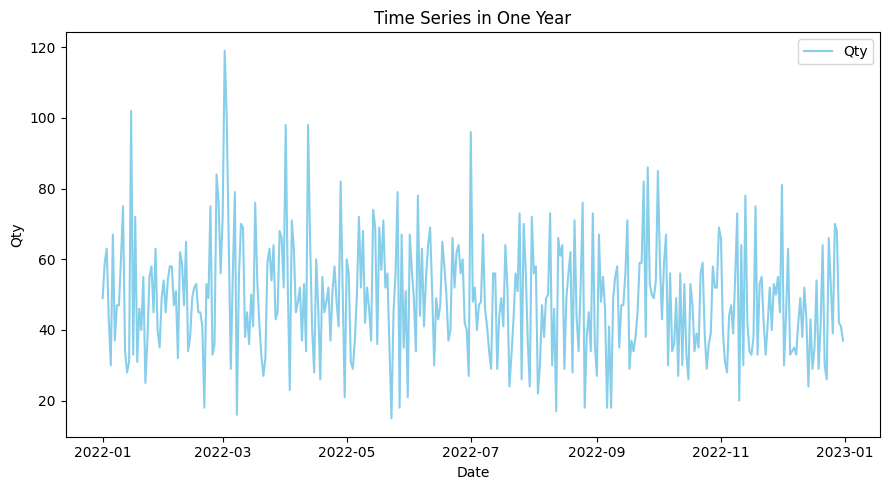

In [21]:
fig, ax = plt.subplots(figsize=(9, 5))
plt.plot(df_forecast.index, df_forecast, color='skyblue', label='Qty')
plt.xlabel('Date')
plt.ylabel('Qty')
plt.title('Time Series in One Year')
plt.legend()
plt.tight_layout()
plt.show()

In [22]:
# Melakukan uji stasioneritas menggunakan Augmented Dickey-Fuller (ADF) test
result = adfuller(df_forecast)
print('ADF Statistic', result[0])
print('p-value:', result[1])
print('Critical Values:')
for key, value in result[4].items():
  print(f'\t{key}: {value}')

if result[1] <= 0.05:
  print('\nThe data is stationary')
else:
  print('\nThe data is non-stationary')

ADF Statistic -19.131655296406315
p-value: 0.0
Critical Values:
	1%: -3.4484434475193777
	5%: -2.869513170510808
	10%: -2.571017574266393

The data is stationary


<Figure size 1200x600 with 0 Axes>

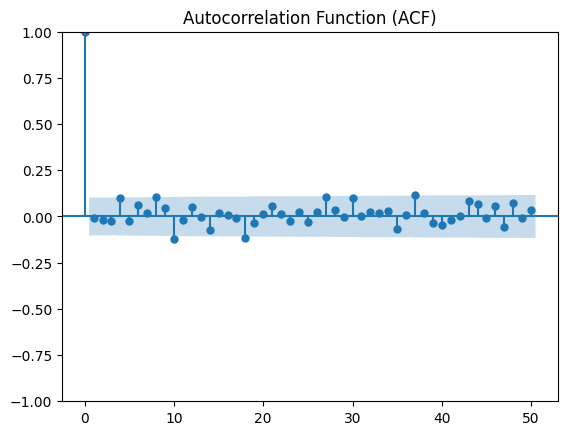

<Figure size 1200x600 with 0 Axes>

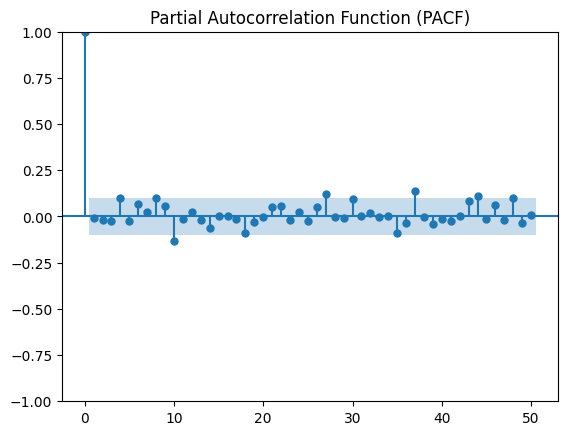

In [23]:
# Plot ACF
plt.figure(figsize=(12, 6))
plot_acf(df_forecast, lags=50, alpha=0.05)
plt.title('Autocorrelation Function (ACF)')
plt.show()

# Plot PACF
plt.figure(figsize=(12, 6))
plot_pacf(df_forecast, lags=50, alpha=0.05)
plt.title('Partial Autocorrelation Function (PACF)')
plt.show()

In [27]:
# Membagi dataset menjadi data train dan data test
cut_off = round(df_forecast.shape[0] * 0.8)
df_train = df_forecast[:cut_off]
df_test = df_forecast[cut_off:]

In [28]:
df_train

,Qty
Date,
2022-01-01,49
2022-01-02,59
2022-01-03,63
2022-01-04,43
2022-01-05,30
...,...
2022-10-15,33
2022-10-16,26
2022-10-17,53


In [29]:
df_test

,Qty
Date,
2022-10-20,39
2022-10-21,35
2022-10-22,56
2022-10-23,59
2022-10-24,39
...,...
2022-12-27,70
2022-12-28,68
2022-12-29,42


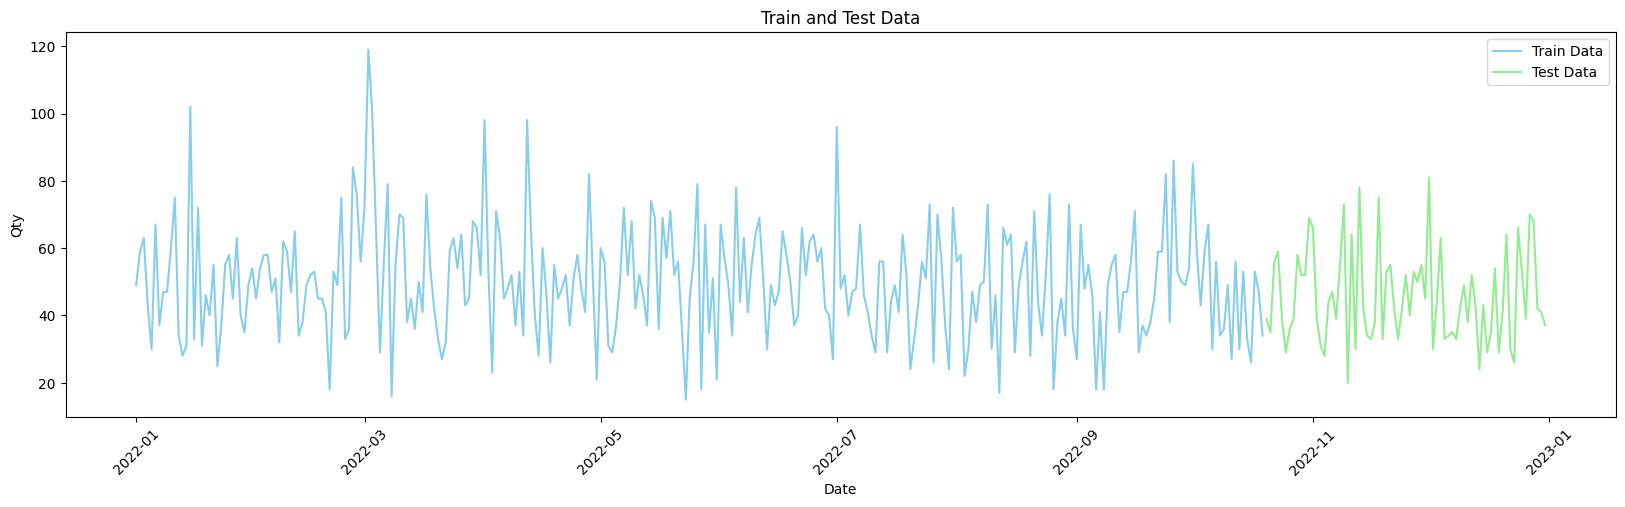

In [30]:
# Plot data train dan data test
plt.figure(figsize=(20, 5))
plt.plot(df_train.index, df_train, label='Train Data', color='skyblue')
plt.plot(df_test.index, df_test, label='Test Data', color='lightgreen')
plt.title('Train and Test Data')
plt.xlabel('Date')
plt.ylabel('Qty')
plt.legend()
plt.xticks(rotation=45)
plt.show()

## ARIMA

In [31]:
# Membangun model ARIMA dengan parameter yang telah ditetapkan
model = sm.tsa.ARIMA(df_train, order=(4, 0, 8))
model_fit = model.fit()

# Menampilkan ringkasan model
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                    Qty   No. Observations:                  292
Model:                 ARIMA(4, 0, 8)   Log Likelihood               -1223.869
Date:                Mon, 18 Dec 2023   AIC                           2475.739
Time:                        06:53:34   BIC                           2527.213
Sample:                    01-01-2022   HQIC                          2496.357
                         - 10-19-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         49.8212      1.173     42.491      0.000      47.523      52.119
ar.L1          0.1116      0.133      0.840      0.401      -0.149       0.372
ar.L2         -1.3907      0.133    -10.458      0.0

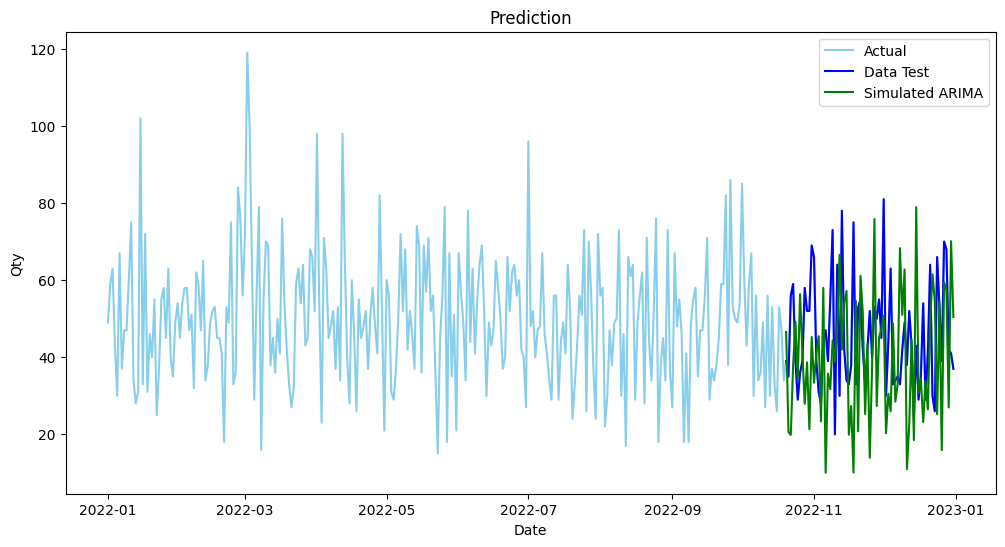

In [32]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm

# Membuat model ARIMA
order = (4, 0, 8)
model = sm.tsa.ARIMA(df_forecast, order=order)
model_fit = model.fit()

# Melakukan prediksi untuk data uji
n_steps = len(df_test)
forecast = model_fit.forecast(steps=n_steps)
forecast_data = pd.DataFrame({'ARIMA Forecast':forecast}, index=df_test.index)

# Simulasi data ARIMA
n_simulated_steps = n_steps
pred = model_fit.get_prediction(start=len(df_forecast), end=len(df_forecast) + n_simulated_steps - 1, dynamic=True )
predicted_values = pred.predicted_mean
std_errors = pred.se_mean
residuals = model_fit.resid
simulated_data = np.zeros(n_simulated_steps)

for i in range(n_simulated_steps):
  simulated_data[i] = predicted_values[i] + np.random.normal(0, std_errors[i]) + residuals[-1]

forecast_data['Simulated ARIMA'] = abs(simulated_data)

# Plotting
plt.figure(figsize=(12,6))
plt.plot(df_forecast.index, df_forecast, label='Actual', color='skyblue')
plt.plot(df_test.index, df_test, label='Data Test', color='blue')
plt.plot(forecast_data.index, forecast_data['Simulated ARIMA'], label='Simulated ARIMA', color='green')
plt.title('Prediction')
plt.xlabel('Date')
plt.ylabel('Qty')
plt.legend()
plt.show()

In [34]:
n_steps = 30
forecast = model_fit.forecast(steps=n_steps)
forecast_data = pd.DataFrame({'ARIMA Forecast': forecast}, index=pd.date_range(start=df_test.index[-1], periods=n_steps+1, freq='D')[1:])

# Simulasi ARIMA
pred = model_fit.get_prediction(start=len(df_forecast), end=len(df_forecast) + n_steps - 1, dynamic=True)
predicted_values = pred.predicted_mean
std_errors = pred.se_mean
residuals = model_fit.resid
simulated_data = np.zeros(n_steps)

for i in range(n_steps):
  simulated_data[i] = predicted_values[i] + np.random.normal(0, std_errors[i] + residuals[-1])
forecast_data['Simulated ARIMA'] = abs(simulated_data)

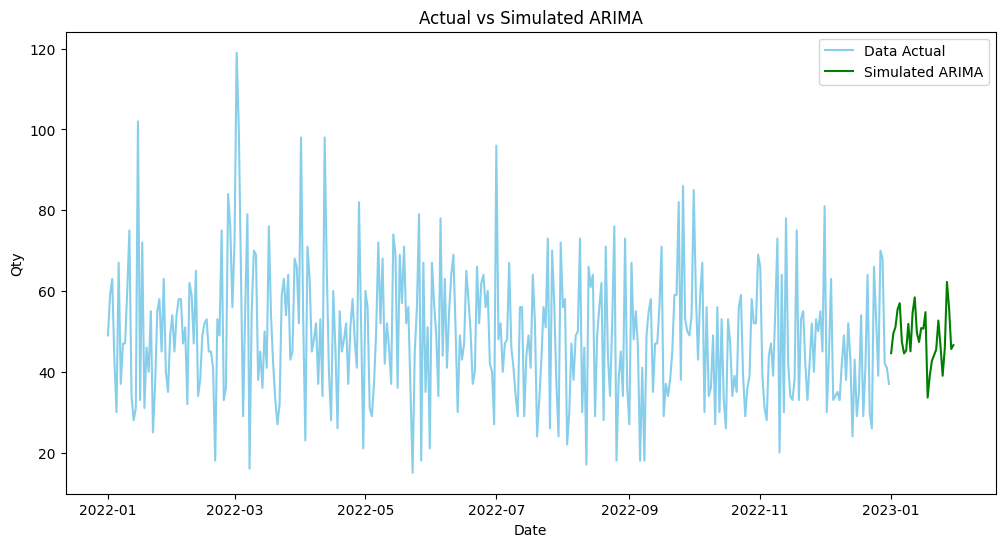

In [36]:
# Plot Prediksi ARIMA
plt.figure(figsize=(12, 6))
plt.plot(df_forecast.index, df_forecast['Qty'], label='Data Actual', color='skyblue')
plt.plot(forecast_data.index, forecast_data['Simulated ARIMA'], label='Simulated ARIMA', color='green')
plt.title('Actual vs Simulated ARIMA')
plt.xlabel('Date')
plt.ylabel('Qty')
plt.legend()
plt.show()

## Clustering

In [37]:
clustering_data = df.groupby('CustomerID').agg({
    'TransactionID' : 'count',
    'Qty' : 'sum',
    'TotalAmount' : 'sum'}).reset_index()
clustering_data = pd.DataFrame(clustering_data)
clustering_data

,CustomerID,TransactionID,Qty,TotalAmount
0,1,17,60,623300
1,2,12,56,382300
2,3,15,56,446200
3,4,10,46,302500
4,5,7,27,268600
...,...,...,...,...
442,443,15,54,410100
443,444,18,62,577700
444,445,18,68,587200
445,446,11,42,423300


In [38]:
clustering_data.nunique()

CustomerID       447
TransactionID     19
Qty               61
TotalAmount      419
dtype: int64

In [39]:
clustering_data = clustering_data.drop(columns='CustomerID', axis=1)
clustering_data

,TransactionID,Qty,TotalAmount
0,17,60,623300
1,12,56,382300
2,15,56,446200
3,10,46,302500
4,7,27,268600
...,...,...,...
442,15,54,410100
443,18,62,577700
444,18,68,587200
445,11,42,423300


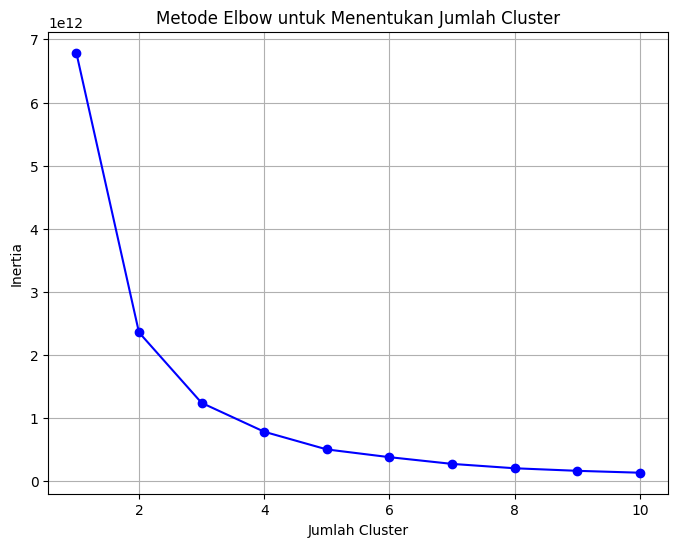

In [41]:
# Menentukan jumlah cluster (gunakan metode Elbow untuk memilih jumlah cluster yang optimal)
inertia = []
for i in range(1, 11):
  kmeans = KMeans(n_clusters=i, random_state=0, n_init=10)
  kmeans.fit(clustering_data)
  inertia.append(kmeans.inertia_)

# Plot Elbow Method untuk menentukan jumlah cluster yang optimal
plt.figure(figsize=(8, 6))
plt.plot(range(1, 11), inertia, marker='o', linestyle='-', color='b')
plt.xlabel('Jumlah Cluster')
plt.ylabel('Inertia')
plt.title('Metode Elbow untuk Menentukan Jumlah Cluster')
plt.grid(True)
plt.show()

In [42]:
# Menentukan cluster yang paling optimal menggunakan KneeLocator
kl = KneeLocator(range(1, 11), inertia, curve='convex', direction='decreasing')
kl.elbow

3

In [44]:
# Membuat 3 cluster
kmeans_3 = KMeans(n_clusters=3, init='k-means++', random_state=0, n_init=10)
clusters = kmeans_3.fit_predict(clustering_data)
clustering_data['Cluster'] = clusters
clustering_data.head()

,TransactionID,Qty,TotalAmount,Cluster
0,17,60,623300,1
1,12,56,382300,0
2,15,56,446200,0
3,10,46,302500,2
4,7,27,268600,2


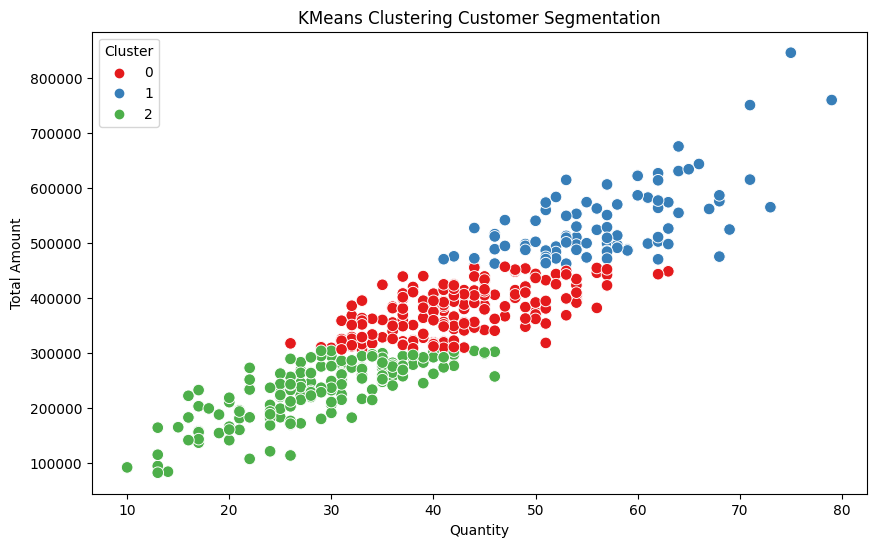

In [45]:
# Menampilkan hasil clustering
plt.figure(figsize=(10,6))
sns.scatterplot(x='Qty', y='TotalAmount', data=clustering_data, hue='Cluster', palette='Set1', s=70)
plt.xlabel('Quantity')
plt.ylabel('Total Amount')
plt.title('KMeans Clustering Customer Segmentation')
plt.legend(title='Cluster')
plt.show()

## Customer Segmentation

In [46]:
# Menghitung rata-rata Qty dan TotalAmount untuk setiap cluster
cluster_avg = clustering_data.groupby('Cluster').agg({
    'Qty':'mean',
    'TotalAmount':'mean'
}).reset_index()

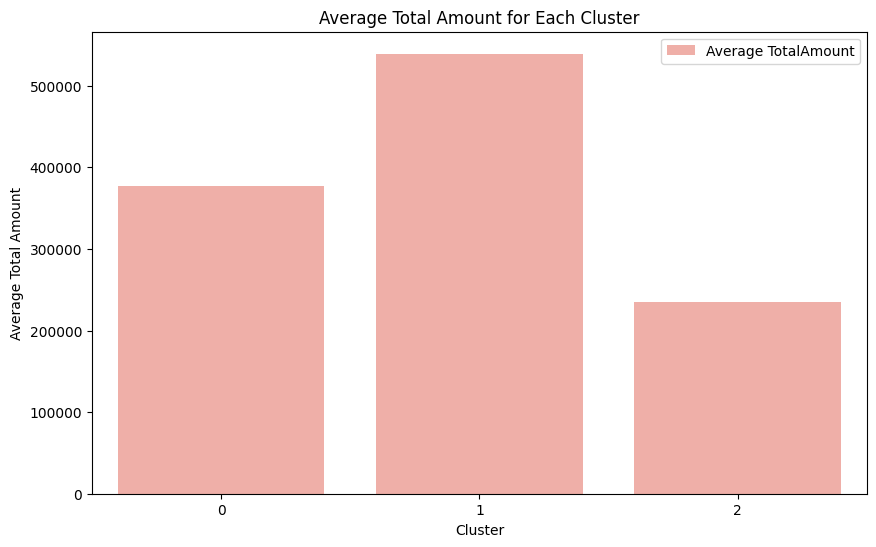

In [47]:
plt.figure(figsize=(10,6))
sns.barplot(x='Cluster', y='TotalAmount', data=cluster_avg, color='salmon', alpha=0.7, label='Average TotalAmount')
plt.xlabel('Cluster')
plt.ylabel('Average Total Amount')
plt.title('Average Total Amount for Each Cluster')
plt.legend()
plt.show()

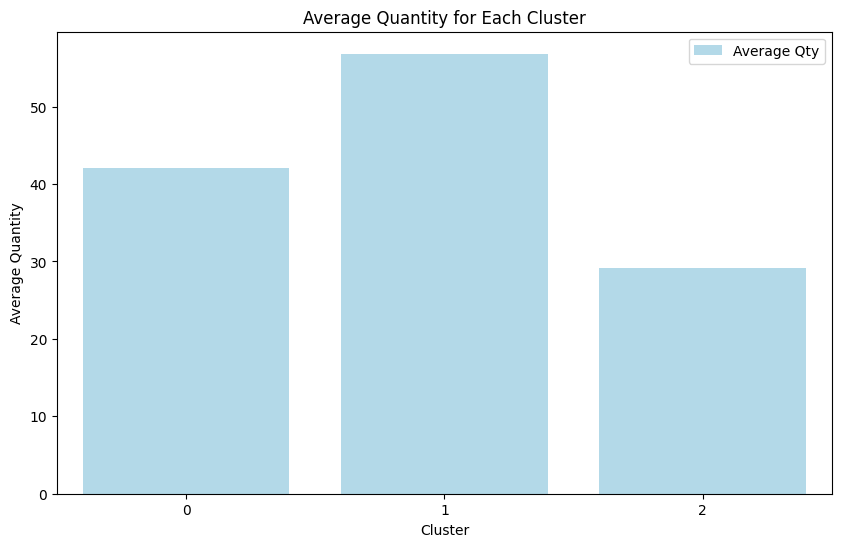

In [48]:
plt.figure(figsize=(10, 6))
sns.barplot(x='Cluster', y='Qty', data=cluster_avg, color='skyblue', alpha=0.7, label='Average Qty')
plt.xlabel('Cluster')
plt.ylabel('Average Quantity')
plt.title('Average Quantity for Each Cluster')
plt.legend()
plt.show()